# Box Office Mojo Modeller

In [1]:
%pylab inline
#% config InlineBackend.figure_format = 'svg'

import pandas as pd
import numpy as np
import seaborn as sns
import patsy
import scipy.stats as stats
sns.set()


from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, lars_path
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.pipeline import Pipeline, make_pipeline

import statsmodels.api as sm
import statsmodels.formula.api as smf 

import matplotlib.pyplot as plt
%matplotlib inline

/Users/kibbles/anaconda3/envs/metis/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Populating the interactive namespace from numpy and matplotlib


## Diagnostic_plot function for later

In [2]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

# Import pickled box office data
Very important to take '\_cleaned.pkl' data

In [3]:
path=('./data/mojo_all_years_movies_cleaned.pkl')

In [4]:
df = pd.read_pickle(path)

## Drop films with DTG < \$ 1 mil

count    15973.000000
mean        13.537541
std          3.228295
min          4.276666
25%         10.848482
50%         13.451091
75%         16.468416
max         20.657833
Name: Log_DTG, dtype: float64


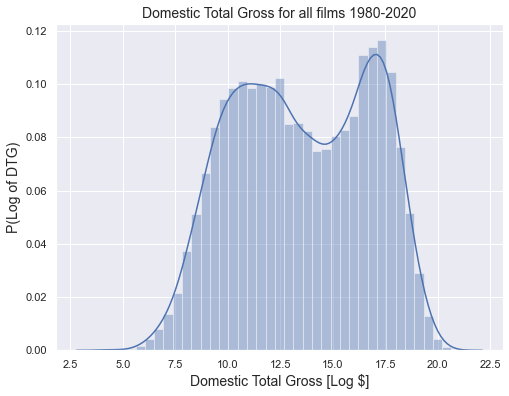

In [5]:
# Examine the current distribution
print(df.Log_DTG.describe())

plt.figure(figsize=(8,6))
sns.distplot(df['Log_DTG'])
plt.xlabel('Domestic Total Gross [Log $]', fontsize=14); plt.ylabel('P(Log of DTG)',fontsize=14);
plt.title('Domestic Total Gross for all films 1980-2020',fontsize=14)
plt.savefig('./data/bimodalLogDTG.svg',format='svg', bbox_inches='tight')

10.309245424763985


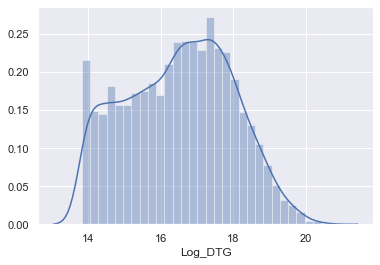

In [6]:
lower_DTG_bound = 1e6
dtg_mean = df.Log_DTG.mean()
dtg_std  = df.Log_DTG.std()
print(dtg_mean - (1*dtg_std))

sns.distplot(df[df.Log_DTG > np.log(lower_DTG_bound) ]['Log_DTG'])

df = df[df.Log_DTG > np.log(lower_DTG_bound) ]

## Drop films with Budget < \$ 1 mil

count    3069.000000
mean       17.212320
std         1.138798
min         9.615805
25%        16.588099
50%        17.312018
75%        17.989898
max        19.690441
Name: Log_Bud, dtype: float64


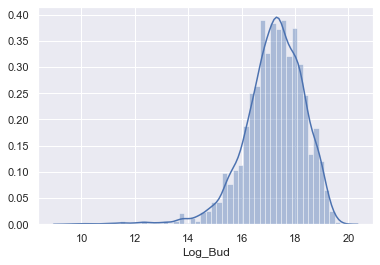

In [7]:
print(df.Log_Bud.describe())
sns.distplot(df['Log_Bud'])

16.073521447100294


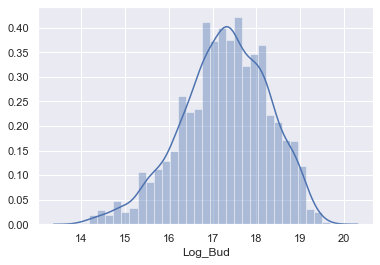

In [8]:
lower_bud_bound = 1e6
bud_mean = df.Log_Bud.mean()
bud_std  = df.Log_Bud.std()
print(bud_mean - (1*bud_std))

sns.distplot(df[df.Log_Bud > np.log(lower_bud_bound) ]['Log_Bud'])

df = df[df.Log_Bud > np.log(lower_bud_bound) ]

## Drop films with DTG > 250 mil

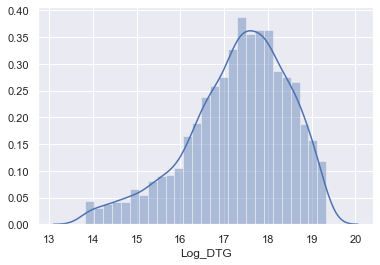

In [9]:
upper_DTG_bound = 250e6
df = df[df.Log_DTG < np.log(upper_DTG_bound) ]
sns.distplot(df['Log_DTG'])

## Examine again

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2910 entries, 1 to 15967
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Movie_Title                 2910 non-null   object        
 1   Domestic_Distributor        2901 non-null   object        
 2   Domestic_Total_Gross        2910 non-null   int64         
 3   Runtime                     2863 non-null   float64       
 4   Rating                      2736 non-null   object        
 5   Release_Date                2910 non-null   datetime64[ns]
 6   Budget                      2910 non-null   float64       
 7   Cast1                       2910 non-null   object        
 8   Cast2                       2910 non-null   object        
 9   Cast3                       2910 non-null   object        
 10  Cast4                       2908 non-null   object        
 11  Director                    2910 non-null   object     

In [11]:
df.describe()

,Domestic_Total_Gross,Runtime,Budget,Intercept,Profit_percent,G,NC-17,Not Rated,PG,PG-13,...,Writer_Score,Producer_Score,Cinematographer_Score,Domestic_Distributor_Score,Cast1_Score,Cast2_Score,Cast3_Score,Cast4_Score,Log_DTG,Log_Bud
count,2.910000e+03,2863.000000,2.910000e+03,2910.0,2910.000000,2910.000000,2910.000000,2910.0,2910.000000,2910.000000,...,1543.000000,2025.000000,2580.000000,2859.000000,2259.000000,1954.000000,1608.000000,1285.000000,2910.000000,2910.000000
mean,5.570266e+07,109.163465,4.573592e+07,1.0,0.955236,0.008247,0.001375,0.0,0.144330,0.383849,...,16.647560,16.805407,15.953417,16.431037,16.550754,16.265107,16.258337,16.233581,17.314255,17.225242
std,5.241996e+07,18.809162,4.201796e+07,0.0,3.760191,0.090456,0.037056,0.0,0.351484,0.486405,...,1.993327,1.740117,1.908877,1.139174,1.815151,1.919583,2.130737,2.198695,1.163436,0.973500
min,1.008098e+06,63.000000,1.200000e+06,1.0,-0.982722,0.000000,0.000000,0.0,0.000000,0.000000,...,6.408529,6.742881,6.535241,8.216088,6.152733,6.663133,6.470800,4.276666,13.823576,13.997832
25%,1.697799e+07,96.000000,1.650000e+07,1.0,-0.433421,0.000000,0.000000,0.0,0.000000,0.000000,...,16.020967,16.264485,15.252869,16.220041,16.038887,15.605574,15.602216,15.412856,16.647428,16.618871
50%,3.811542e+07,106.000000,3.200000e+07,1.0,0.114435,0.000000,0.000000,0.0,0.000000,0.000000,...,17.132541,17.220484,16.466044,16.826357,17.005020,16.719367,16.821594,16.751940,17.456129,17.281246
75%,7.673343e+07,119.000000,6.000000e+07,1.0,1.097999,0.000000,0.000000,0.0,0.000000,1.000000,...,17.928518,17.896209,17.268570,17.102618,17.687189,17.496175,17.619554,17.730237,18.155847,17.909855
max,2.499760e+08,242.000000,2.750000e+08,1.0,122.365901,1.000000,1.000000,0.0,1.000000,1.000000,...,19.920614,20.092487,19.681999,18.598098,20.449497,19.920614,20.098215,20.657833,19.336875,19.432282


## correlation

In [12]:
df.corr()

,Domestic_Total_Gross,Runtime,Budget,Intercept,Profit_percent,G,NC-17,Not Rated,PG,PG-13,...,Writer_Score,Producer_Score,Cinematographer_Score,Domestic_Distributor_Score,Cast1_Score,Cast2_Score,Cast3_Score,Cast4_Score,Log_DTG,Log_Bud
Domestic_Total_Gross,1.000000,0.185504,0.566155,NaN,0.251811,0.060272,-0.033631,NaN,0.123934,0.099844,...,0.263610,0.288384,0.206463,0.294050,0.149576,0.113964,0.084023,0.098104,0.838245,0.499557
Runtime,0.185504,1.000000,0.252567,NaN,-0.056657,-0.070876,0.034482,NaN,-0.197892,0.049403,...,0.001314,0.016551,0.081886,-0.041675,-0.020565,0.005281,-0.052172,-0.013456,0.135925,0.256419
Budget,0.566155,0.252567,1.000000,NaN,-0.213509,0.027028,-0.022728,NaN,0.143180,0.174803,...,0.248872,0.308527,0.270371,0.339255,0.169877,0.093325,0.059974,0.100242,0.504314,0.859826
Intercept,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Profit_percent,0.251811,-0.056657,-0.213509,NaN,1.000000,0.161064,-0.014398,NaN,-0.014271,-0.057063,...,0.020304,-0.001494,-0.101320,-0.097517,-0.056350,-0.022179,-0.008352,-0.009516,0.255874,-0.353427
G,0.060272,-0.070876,0.027028,NaN,0.161064,1.000000,-0.003383,NaN,-0.037453,-0.071977,...,0.025167,0.046368,0.056153,0.034413,-0.047573,-0.024900,0.030348,0.028298,0.049667,0.003706
NC-17,-0.033631,0.034482,-0.022728,NaN,-0.014398,-0.003383,1.000000,NaN,-0.015237,-0.029283,...,-0.019353,-0.050164,-0.009088,-0.044753,-0.024515,-0.063970,0.007906,NaN,-0.054706,-0.026746
Not Rated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PG,0.123934,-0.197892,0.143180,NaN,-0.014271,-0.037453,-0.015237,NaN,1.000000,-0.324161,...,0.070049,0.108430,0.094677,0.139146,0.033140,0.004478,0.089585,0.050272,0.132736,0.135051
PG-13,0.099844,0.049403,0.174803,NaN,-0.057063,-0.071977,-0.029283,NaN,-0.324161,1.000000,...,0.064700,0.079262,0.058460,0.103525,0.079866,0.040594,-0.021759,-0.004170,0.127779,0.173426


# Define subset

In [384]:
subset = (['Log_DTG','Intercept','Log_Bud','Domestic_Distributor_Score',
           'R',])
#'Cast1_Score','Writer_Score','Director_Score','Producer_Score'
#'PG','PG-13','Runtime'

In [385]:
features = df[subset]
features[['Domestic_Distributor_Score']] = features[['Domestic_Distributor_Score']].fillna(0)
features = features.dropna()
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2910 entries, 1 to 15967
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Log_DTG                     2910 non-null   float64
 1   Intercept                   2910 non-null   int64  
 2   Log_Bud                     2910 non-null   float64
 3   Domestic_Distributor_Score  2910 non-null   float64
 4   R                           2910 non-null   uint8  
dtypes: float64(3), int64(1), uint8(1)
memory usage: 116.5 KB


/Users/kibbles/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


## Compare Log Budget to Log DTG

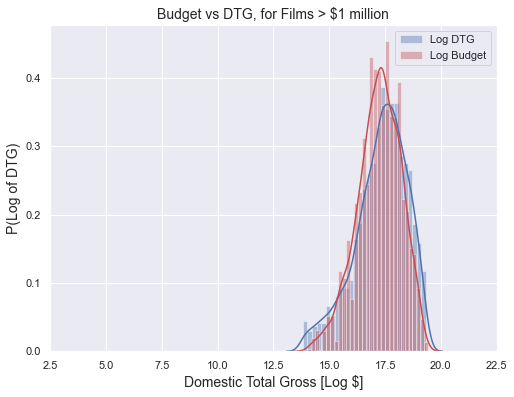

In [386]:
plt.figure(figsize=(8,6))
sns.distplot(features['Log_DTG'])
sns.distplot(features['Log_Bud'],color='r')
plt.xticks([2.5,5.0,7.5,10.0,12.5,15.0,17.5,20.0,22.5])
plt.xlabel('Domestic Total Gross [Log $]', fontsize=14); plt.ylabel('P(Log of DTG)',fontsize=14);
plt.legend(['Log DTG','Log Budget']); plt.title('Budget vs DTG, for Films > $1 million',fontsize=14)
plt.savefig('./data/budvsdtg.svg',format='svg', bbox_inches='tight')

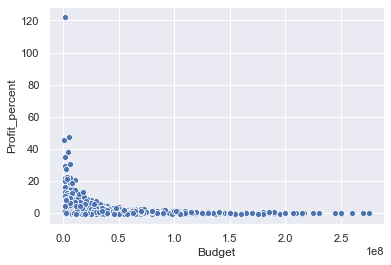

In [387]:
sns.scatterplot(x=df['Budget'], y=df['Profit_percent'], )

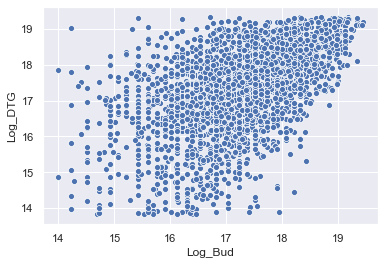

In [388]:
sns.scatterplot(x=features['Log_Bud'], y=features['Log_DTG'], )

## Pairplot of Subset

In [389]:
#sns.pairplot(features)

# Model init and fitting
___

In [390]:
state = 30
splits = 5
kf = KFold(n_splits=splits, shuffle=True, random_state = state)

In [391]:
X = features.loc[:, features.columns != 'Log_DTG']
y = features['Log_DTG']

In [392]:
#Split the data 80 - 20 train/test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=state)

(print(#'Training cols: ',X_train.columns,'\n',
       ' Train+Val set dims:   ', X_train_val.shape,'\n',
       'Testing set dims:    ', X_test.shape,'\n',
))

# Split into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=state)
(print(#'Training cols: ',X_train.columns,'\n',
       ' Training set dims:   ', X_train.shape,'\n',
       'Validation set dims: ', X_val.shape,'\n',
       'Testing set dims:    ', X_test.shape,'\n',
))


 Train+Val set dims:    (2328, 4) 
 Testing set dims:     (582, 4) 

 Training set dims:    (1746, 4) 
 Validation set dims:  (582, 4) 
 Testing set dims:     (582, 4) 



In [393]:
## Scale the variables
std = preprocessing.StandardScaler()
std.fit(X_train_val.values)

## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train_val.values)
X_te = std.transform(X_test.values)

## Initialize all models

In [394]:
degree = 2
alphavec = 10**np.linspace(-2,2,200)

# lm = LinearRegression()
lm = make_pipeline(preprocessing.PolynomialFeatures(degree), LinearRegression())

lasso_model = LassoCV(alphas = alphavec, cv=5)
# lasso_model = make_pipeline(preprocessing.PolynomialFeatures(degree), LassoCV(alphas = alphavec, cv=5))
ridge_model = RidgeCV(alphas = alphavec, cv=5)
# ridge_model = make_pipeline(preprocessing.PolynomialFeatures(degree), RidgeCV(alphas = alphavec, cv=5))

## statsmodels OLS

In [395]:
# Create your model
#X_tr = sm.add_constant(std.fit_transform(X_train_val))
statsmodel = sm.OLS(y_train, X_train) 


# Fit your model to your training set
stats_fit = statsmodel.fit()

## OLS (Polynomial)

In [396]:
from sklearn.model_selection import cross_val_score

lm.fit(X_train_val, y_train_val)

cross_val_score(lm, X, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([0.29850104, 0.45246612, 0.40700629, 0.31900408, 0.16838853])

## LASSO

In [397]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

lasso_model.fit(X_tr, y_train_val)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

### LASSO LARS path

In [398]:
## Note: lars_path takes numpy matrices, not pandas dataframes

print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y_train_val.values, method='lasso')

Computing regularization path using the LARS ...


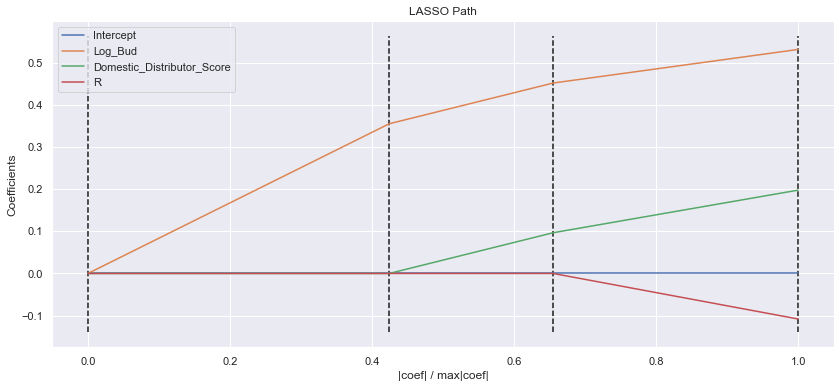

In [399]:
# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(14,6))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|'); plt.ylabel('Coefficients'); plt.title('LASSO Path')
plt.axis('tight'); plt.legend(X_train.columns); plt.show()

## Ridge

In [400]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha


ridge_model.fit(X_tr, y_train_val)

RidgeCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

### Ridge LARS path

In [401]:
## Note: lars_path takes numpy matrices, not pandas dataframes
print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y_train_val.values, method='ridge')

Computing regularization path using the LARS ...


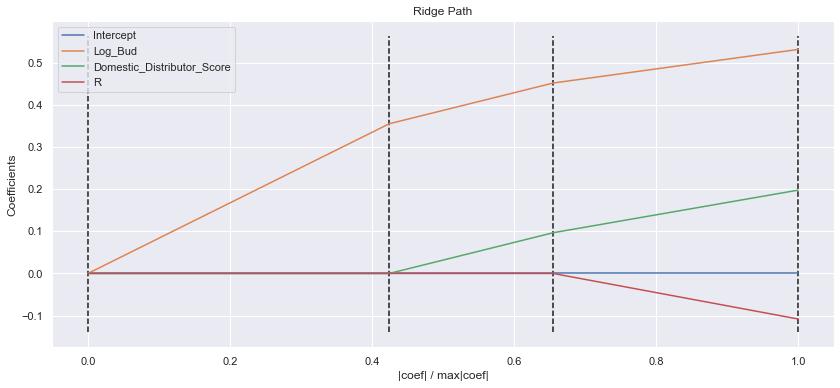

In [402]:
# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(14,6))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|'); plt.ylabel('Coefficients'); plt.title('Ridge Path')
plt.axis('tight'); plt.legend(X_train_val.columns); plt.show()

# Results
___

## Results: Statsmodels OLS

In [403]:
# Print summary statistics of the model's performance
stats_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Log_DTG   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     258.5
Date:                Thu, 16 Apr 2020   Prob (F-statistic):          9.56e-139
Time:                        23:12:47   Log-Likelihood:                -2411.6
No. Observations:                1746   AIC:                             4831.
Df Residuals:                    1742   BIC:                             4853.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      6.8861      0.421     16.338      0.000       6.059       7.713
Log_Bud                        0.5329      0.025     21.260      0.000       0.484       0.582
Domestic_Distributor_Score     0.0834      0.011      7.942      0.000       0.063       0.104
R                             -0.2184      0.048     -4.549      0.000      -0.313      -0.124
==============================================================================
Omnibus:                       53.382   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.724
Skew:                          -0.410   Prob(JB):                     1.77e-13
Kurtosis:                       3.365   Cond. No.                         434.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Results: LASSO

In [404]:
lasso_model.alpha_

0.01

In [405]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X_train_val.columns, lasso_model.coef_))

[('Intercept', 0.0),
 ('Log_Bud', 0.5263514718199807),
 ('Domestic_Distributor_Score', 0.19046947433698053),
 ('R', -0.10015769143084532)]

In [406]:
# Make predictions on the test set using the new model
lasso_test_set_pred = lasso_model.predict(X_te)

In [407]:
lasso_r2 = r2_score(y_test, lasso_test_set_pred)
print(lasso_r2)

0.3323820899395997


In [408]:
n = len(X_test)
p = X_test.shape[1]
lasso_adj_r2 = 1-(1-lasso_r2)*(n-1)/(n-p-1)
print(lasso_adj_r2)

0.3277538895232365


In [409]:
lasso_mae = np.abs(np.exp(y_test) - np.exp(lasso_test_set_pred)).sum() / len(X_test)
(lasso_mae)

29071682.618774977

In [410]:
lasso_rmse = np.sqrt( ((np.exp(y_test) - np.exp(lasso_test_set_pred))**2).sum() ) / len(X_test)
lasso_rmse

1770456.5768254902

In [411]:
lasso_results = {'R2': lasso_r2,
               'Adj R2': lasso_adj_r2,
               'MAE': lasso_mae,
               'RMSE': lasso_rmse,
              }

## Results: Ridge

In [412]:
# This is the best alpha value it found - not far from the value
# selected using simple validation
ridge_model.alpha_

41.50404757850477

In [413]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X_train_val.columns, ridge_model.coef_))

[('Intercept', 0.0),
 ('Log_Bud', 0.5231536745935454),
 ('Domestic_Distributor_Score', 0.1972284348362212),
 ('R', -0.10836716715395348)]

In [414]:
# Make predictions on the test set using the new model
ridge_test_set_pred = ridge_model.predict(X_te)

In [415]:
ridge_r2 = r2_score(y_test, ridge_test_set_pred)
print(ridge_r2)

0.3322919762630363


In [416]:
n = len(X_test)
p = X_test.shape[1]
ridge_adj_r2 = 1-(1-ridge_r2)*(n-1)/(n-p-1)
print(ridge_adj_r2)

0.32766315114180955


In [417]:
ridge_mae = np.abs(np.exp(y_test) - np.exp(ridge_test_set_pred)).sum() / len(X_test)
(ridge_mae)

29047994.80718679

In [418]:
ridge_rmse = np.sqrt( ((np.exp(y_test) - np.exp(ridge_test_set_pred))**2).sum() ) / len(X_test)
ridge_rmse

1768574.8353525617

In [419]:
ridge_results = {'R2': ridge_r2,
               'Adj R2': ridge_adj_r2,
               'MAE': ridge_mae,
               'RMSE': ridge_rmse,
              }

## Results: OLS

In [420]:
ols_test_set_pred = lm.predict(X_test)

In [421]:
ols_r2 = r2_score(y_test, ols_test_set_pred)
print(ols_r2)

0.3321770055266019


In [422]:
n = len(X_test)
p = X_test.shape[1]
ols_adj_r2 = 1-(1-ols_r2)*(n-1)/(n-p-1)
(ols_adj_r2)

0.3275473833812057

In [423]:
ols_mae = np.abs(np.exp(y_test) - np.exp(ols_test_set_pred)).sum() / len(X_test)
(ols_mae)

28591275.37401057

In [424]:
ols_rmse = np.sqrt( ((np.exp(y_test) - np.exp(ols_test_set_pred))**2).sum() ) / len(X_test)
ols_rmse

1751858.0890346467

In [425]:
lm.steps[1][1].coef_

array([ 0.00000000e+00,  1.63064007e-16, -1.68023841e+00, -1.86901549e-01,
       -1.30235814e-01, -5.55111512e-16, -1.68023841e+00, -1.86901549e-01,
       -1.30235814e-01,  1.07147226e-01,  1.11148722e-02,  3.56032237e-05,
        1.43772283e-02,  1.52942845e-02, -1.30235814e-01])

In [426]:
ols_results = {'R2': ols_r2,
               'Adj R2': ols_adj_r2,
               'MAE': ols_mae,
               'RMSE': ols_rmse,
              }

## Cross-validation results

### Cross-validation code ------------------ _Computationally expensive_

#### Cross-Validation OLS

In [427]:
model = lm

scoring_dict = {'R2':   'r2',
                'MAE':  'neg_mean_absolute_error',
                'RMSE': 'neg_root_mean_squared_error'
               }
n = len(X_train_val)/splits
p = X_train_val.shape[1]
ols_cv_r2 = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring=scoring_dict['R2']))
ols_cv_adj_r2 = 1-(1-ols_cv_r2)*(n-1)/(n-p-1)
ols_cv_mae = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring=scoring_dict['MAE']))
ols_cv_rmse = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring=scoring_dict['RMSE']))
print('Cross-Validation scoring for OLS:')
print(f'Linear Regression val R2: {ols_cv_r2:.3f}')
print(f'Linear Regression val Adj_R2: {ols_cv_adj_r2:.3f}')
print(f'Linear Regression val MAE: {-ols_cv_mae:.3f}')
print(f'Linear Regression val RMSE: {-ols_cv_rmse:.3f}')


Cross-Validation scoring for OLS:
Linear Regression val R2: 0.344
Linear Regression val Adj_R2: 0.339
Linear Regression val MAE: 0.743
Linear Regression val RMSE: 0.945


In [428]:
cross_val_score(lm, X_train_val, y_train_val, cv=kf, scoring=scoring_dict['MAE'])

array([-0.75287194, -0.77483603, -0.71082117, -0.74128152, -0.73381413])

#### Cross-validation LASSO

In [429]:
model = lasso_model

scoring_dict = {'R2':   'r2',
                'MAE':  'neg_mean_absolute_error',
                'RMSE': 'neg_root_mean_squared_error'
               }
n = len(X_train_val)/splits
p = X_train_val.shape[1]
lasso_cv_r2 = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring=scoring_dict['R2']))
lasso_cv_adj_r2 = 1-(1-lasso_cv_r2)*(n-1)/(n-p-1)
lasso_cv_mae = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring=scoring_dict['MAE']))
lasso_cv_rmse = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring=scoring_dict['RMSE']))
print('Cross-Validation scoring for lasso:')
print(f'Linear Regression val R2: {lasso_cv_r2:.3f}')
print(f'Linear Regression val Adj_R2: {lasso_cv_adj_r2:.3f}')
print(f'Linear Regression val MAE: {-lasso_cv_mae:.3f}')
print(f'Linear Regression val RMSE: {-lasso_cv_rmse:.3f}')


Cross-Validation scoring for lasso:
Linear Regression val R2: 0.307
Linear Regression val Adj_R2: 0.301
Linear Regression val MAE: 0.763
Linear Regression val RMSE: 0.972


#### Cross-Validation Ridge

In [430]:
model = ridge_model

scoring_dict = {'R2':   'r2',
                'MAE':  'neg_mean_absolute_error',
                'RMSE': 'neg_root_mean_squared_error'
               }
n = len(X_train_val)/splits
p = X_train_val.shape[1]
ridge_cv_r2 = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring=scoring_dict['R2']))
ridge_cv_adj_r2 = 1-(1-ridge_cv_r2)*(n-1)/(n-p-1)
ridge_cv_mae = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring=scoring_dict['MAE']))
ridge_cv_rmse = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring=scoring_dict['RMSE']))
print('Cross-Validation scoring for ridge:')
print(f'Linear Regression val R2: {ridge_cv_r2:.3f}')
print(f'Linear Regression val Adj_R2: {ridge_cv_adj_r2:.3f}')
print(f'Linear Regression val MAE: {-ridge_cv_mae:.3f}')
print(f'Linear Regression val RMSE: {-ridge_cv_rmse:.3f}')


Cross-Validation scoring for ridge:
Linear Regression val R2: 0.307
Linear Regression val Adj_R2: 0.301
Linear Regression val MAE: 0.763
Linear Regression val RMSE: 0.971


### Dictionaries for each model

In [431]:
# OLS
cv_ols = {'R2': ols_cv_r2,
          'Adj R2': ols_cv_adj_r2,
          'MAE': np.exp(ols_cv_mae),
          'RMSE': np.exp(ols_cv_rmse),
         }
cv_ols

{'R2': 0.3444142611540527,
 'Adj R2': 0.3387209416677657,
 'MAE': 0.47581556940311776,
 'RMSE': 0.3886083799037674}

In [432]:
# LASSO
cv_lasso = {'R2': lasso_cv_r2,
          'Adj R2': lasso_cv_adj_r2,
          'MAE': np.exp(lasso_cv_mae),
          'RMSE': np.exp(lasso_cv_rmse),
         }
cv_lasso

{'R2': 0.3070904651730776,
 'Adj R2': 0.3010730137199562,
 'MAE': 0.4662976079082073,
 'RMSE': 0.378504990110542}

In [433]:
# Cross-Validation statistics
cv_ridge = {'R2': ridge_cv_r2,
          'Adj R2': ridge_cv_adj_r2,
          'MAE': np.exp(ridge_cv_mae),
          'RMSE': np.exp(ridge_cv_rmse),
         }
cv_ridge

{'R2': 0.30740756937325325,
 'Adj R2': 0.3013928717559996,
 'MAE': 0.4663482773126882,
 'RMSE': 0.3785875898126066}

### Cross-Validation statistics, collated

In [434]:
results_models = ['OLS', 'LASSO', 'Ridge']
results_cols = ['R2','Adj R2','MAE','RMSE']

cv_results_df = pd.DataFrame(index = results_models, columns = results_cols)
cv_results_df.loc['OLS'] = cv_ols
cv_results_df.loc['Ridge'] = cv_ridge
cv_results_df.loc['LASSO'] = cv_lasso
cv_results_df

,R2,Adj R2,MAE,RMSE
OLS,0.344414,0.338721,0.475816,0.388608
LASSO,0.30709,0.301073,0.466298,0.378505
Ridge,0.307408,0.301393,0.466348,0.378588


## Test results

In [435]:
results_df = pd.DataFrame(index = results_models, columns = results_cols)
results_df.loc['OLS'] = ols_results
results_df.loc['Ridge'] = ridge_results
results_df.loc['LASSO'] = lasso_results
results_df

,R2,Adj R2,MAE,RMSE
OLS,0.332177,0.327547,2.85913e+07,1.75186e+06
LASSO,0.332382,0.327754,2.90717e+07,1.77046e+06
Ridge,0.332292,0.327663,2.9048e+07,1.76857e+06


# Test result plots

## Residuals

### Statsmodels residuals

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'Statsmodels Residuals')

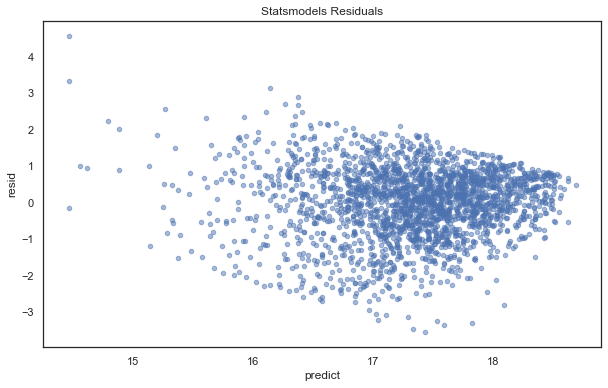

In [436]:
# create residual plot
sm_residuals = pd.DataFrame()
sm_residuals['predict']=stats_fit.predict(X_train_val)
sm_residuals['resid']= y_train_val-sm_residuals.predict
with sns.axes_style('white'):
    plot = sm_residuals.plot(
        kind='scatter', x='predict', y='resid', alpha=0.5, figsize=(10,6));
plt.title('Statsmodels Residuals')

### OLS residuals

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'OLS Residuals')

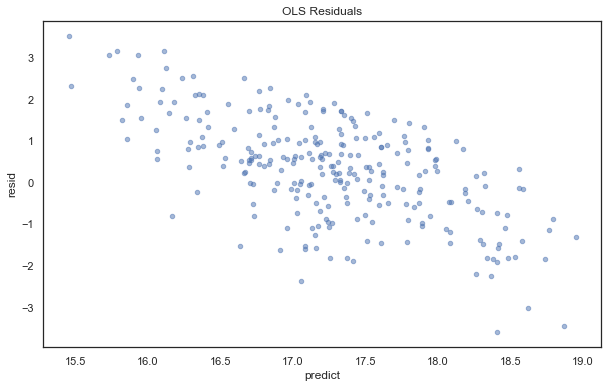

In [437]:
# create residual plot
lm_residuals = pd.DataFrame()
lm_residuals['predict']=lm.predict(X_train_val)
lm_residuals['resid']= y_train_val-lm_residuals.predict
with sns.axes_style('white'):
    plot = lm_residuals.plot(
        kind='scatter', x='predict', y='resid', alpha=0.5, figsize=(10,6));
plt.title('OLS Residuals')

### LASSO residuals

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'LASSO Residuals')

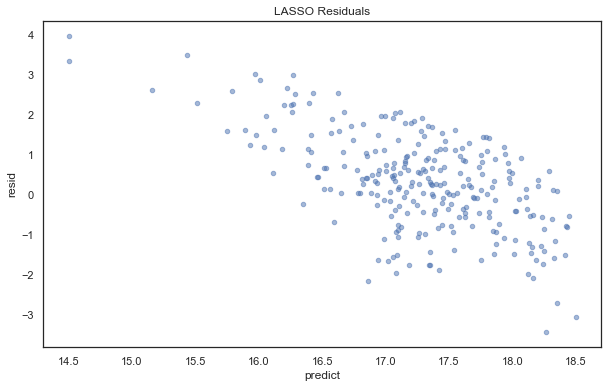

In [438]:
# create residual plot
lasso_residuals = pd.DataFrame()
lasso_residuals['predict']=lasso_model.predict(X_tr)
lasso_residuals['resid']= y_train_val-lasso_residuals.predict
with sns.axes_style('white'):
    plot = lasso_residuals.plot(
        kind='scatter', x='predict', y='resid', alpha=0.5, figsize=(10,6));
plt.title('LASSO Residuals')

### Ridge residuals

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'Ridge Residuals')

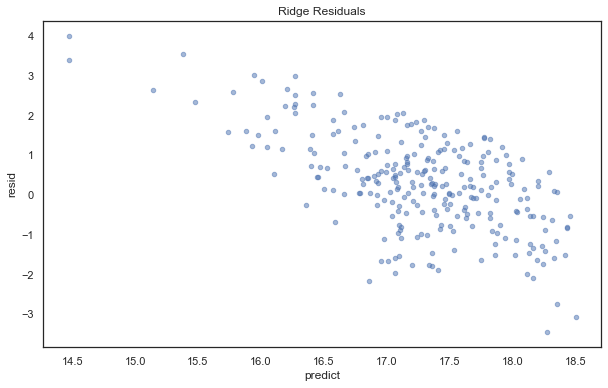

In [439]:
# create residual plot
ridge_residuals = pd.DataFrame()
ridge_residuals['predict']=ridge_model.predict(X_tr)
ridge_residuals['resid']= y_train_val-ridge_residuals.predict
with sns.axes_style('white'):
    plot = ridge_residuals.plot(
        kind='scatter', x='predict', y='resid', alpha=0.5, figsize=(10,6));
plt.title('Ridge Residuals')

### Residuals from all models

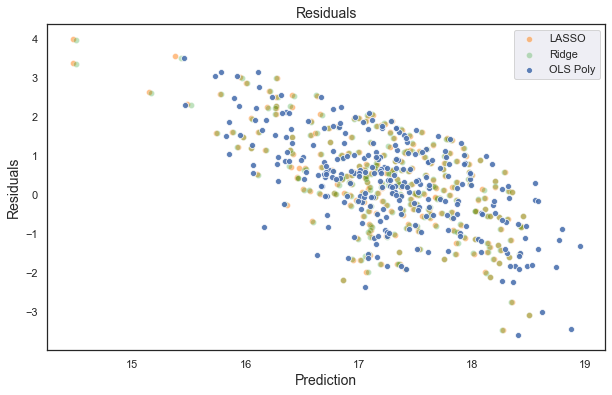

In [459]:
with sns.axes_style('white'):
    plt.subplots( figsize=(10,6))
    sns.scatterplot(
        data=ridge_residuals, x='predict', y='resid', alpha=0.5, color='tab:orange');
    sns.scatterplot(
        data=lasso_residuals, x='predict', y='resid', alpha=0.3, color='tab:green');
    sns.scatterplot(
        data = lm_residuals, x='predict', y='resid', alpha=0.9, color='b');
plt.title('Residuals', fontsize=14), plt.legend(['LASSO','Ridge','OLS Poly'],loc='upper right')
plt.xlabel('Prediction',fontsize=14); plt.ylabel('Residuals',fontsize=14);
plt.savefig('./data/Residuals.svg',formate='svg',bbox_inches='tight')

## Predicted-Observed Test Results

In [440]:
models = {'OLS': lm, 'LASSO': lasso_model, 'Ridge': ridge_model}

## All models Predicted-Observed Test Results

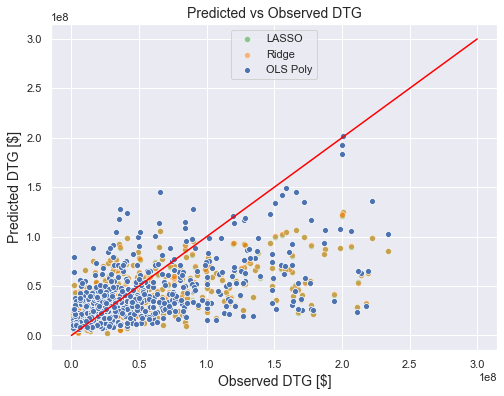

In [441]:
plt.figure(figsize=(8,6))

sns.scatterplot(x=np.exp(y_test), y=np.exp(lasso_test_set_pred), color='tab:green', alpha=0.5);
sns.scatterplot(x=np.exp(y_test), y=np.exp(ridge_test_set_pred), color='tab:orange', alpha=0.5);
sns.scatterplot(x=np.exp(y_test), y=np.exp(ols_test_set_pred));
#sns.relplot(x=np.exp(y_test), y=np.exp(ols_test_set_pred), kind="line", ci=lm.predict(X_test));

plt.xlabel('Observed DTG [$]', fontsize=14); plt.ylabel('Predicted DTG [$]', fontsize=14);
plt.title('Predicted vs Observed DTG', fontsize=14); plt.legend(['LASSO','Ridge','OLS Poly'], loc='upper center')
plt.plot((0,3e8), (0,3e8), c='red');
plt.savefig('./data/predvsobsDTG.png',format='png', bbox_inches='tight')

## OLS, LASSO, Ridge QQ plots

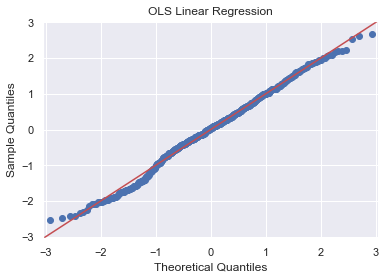

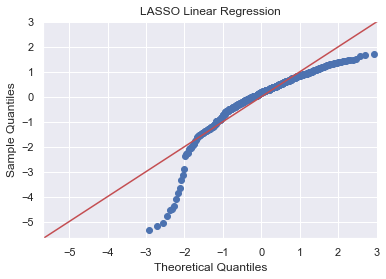

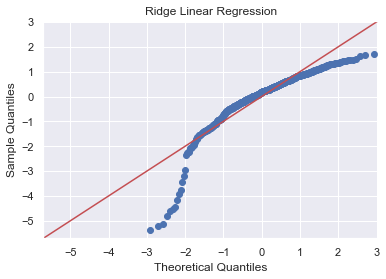

In [442]:
# Prediction vs Reality.
import pylab as py

models = {'OLS': lm, 'LASSO': lasso_model, 'Ridge': ridge_model}
for model in models:
    sm.qqplot(models[model].predict(X_test), line='45', fit=True)
    plt.title(model+' Linear Regression')
    plt.savefig('./data/'+model+'QQ.svg', format = 'svg', bbox_inches='tight')
    #py.show()